In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import normaltest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
import scipy.interpolate as sci
import scipy.optimize as sco
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import scipy.optimize as scomo
import pandas as pd 
import os
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pmdarima as pm

In [2]:
folder_path = 'C:\\Users\\akshi_sh9bvdj\\Downloads\\archive\\stock_market_data\\forbes2000\\csv'
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
dataframes = [pd.read_csv(os.path.join(folder_path, file)) for file in csv_files]
# Combine All the datasets into 1
dataframes = []
for file in csv_files:
    # Read the CSV
    df = pd.read_csv(os.path.join(folder_path, file))
    
    # Add a new column representing the filename without the ".csv" extension
    filename_without_extension = os.path.splitext(file)[0]
    df.insert(0, 'Name', filename_without_extension)
    df['Name'] = filename_without_extension
    dataframes.append(df)

# Concatenate all DataFrames
stocks_df = pd.concat(dataframes, ignore_index=True)

# Save new merged Dataset
stocks_df.to_csv('merged_dataset_with_id.csv', index=False)

## ARIMA - AutoRegressive Integrated Moving Average

### The ARIMA model was fitted to historical stock price data, specifically the "Close" prices. The order of the ARIMA model was determined by iterating over different combinations of AR (Autoregressive) and MA (Moving Average) parameters.

### Once the ARIMA model was fitted and the optimal parameters were determined, the forecasted values were obtained using the forecast() function. The forecasted values were then plotted on a graph along with the corresponding dates.

### We will implement the ARIMA model for only Tesla and Microsoft stocks.

In [3]:
# Convert Date column to datetime
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'], format='%d-%m-%Y')
# Filter out Tesla data
tesla_df = stocks_df[stocks_df['Name'] == 'TSLA']

# Sort the dataframe by Date
tesla_df.sort_values(by='Date', inplace=True)
print(tesla_df)

         Name       Date         Low        Open       Volume        High  \
5031552  TSLA 2010-06-29    1.169333    1.266667  281494500.0    1.666667   
5031553  TSLA 2010-06-30    1.553333    1.719333  257806500.0    2.028000   
5031554  TSLA 2010-07-01    1.351333    1.666667  123282000.0    1.728000   
5031555  TSLA 2010-07-02    1.247333    1.533333   77097000.0    1.540000   
5031556  TSLA 2010-07-06    1.055333    1.333333  103003500.0    1.333333   
...       ...        ...         ...         ...          ...         ...   
5034684  TSLA 2022-12-06  175.330002  181.220001   92150800.0  183.649994   
5034685  TSLA 2022-12-07  172.220001  175.029999   84213300.0  179.380005   
5034686  TSLA 2022-12-08  169.059998  172.199997   97624500.0  175.199997   
5034687  TSLA 2022-12-09  173.360001  173.839996  104746600.0  182.500000   
5034688  TSLA 2022-12-12  170.389999  176.100006   36780366.0  177.359894   

              Close  Adjusted Close  
5031552    1.592667        1.592667  

C:\Users\akshi_sh9bvdj\AppData\Local\Temp\ipykernel_14784\632218731.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tesla_df.sort_values(by='Date', inplace=True)


In [4]:
# Assuming 'Date' column is present in msft_df and is properly formatted
tesla_df['Date'] = pd.to_datetime(tesla_df['Date'])
tesla_df.set_index('Date', inplace=True)

C:\Users\akshi_sh9bvdj\AppData\Local\Temp\ipykernel_14784\116049003.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tesla_df['Date'] = pd.to_datetime(tesla_df['Date'])


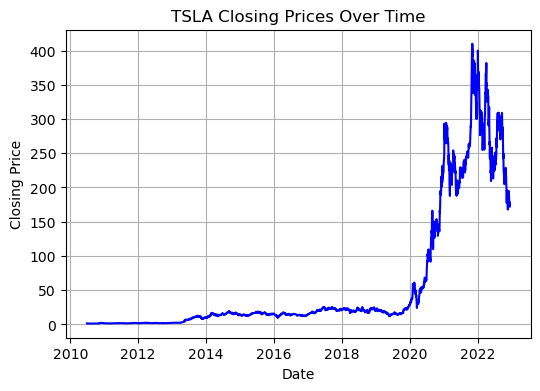

In [5]:
# Plot the time series
plt.figure(figsize=(6, 4))
plt.plot(tesla_df.index,tesla_df['Close'], color='blue')
plt.title('TSLA Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

In [6]:
tesla_df.shape

(3137, 7)

In [7]:
from sklearn.model_selection import train_test_split

# Assuming tesla_df is your DataFrame with shape (3137, 8)
train_size = 0.80
test_size = 1 - train_size

# Splitting into training and testing sets
df_train, df_test = train_test_split(tesla_df, test_size=test_size, random_state=52)

# Checking the shapes of the resulting DataFrames
print("Shape of df_train:", df_train.shape)
print("Shape of df_test:", df_test.shape)

Shape of df_train: (2509, 7)
Shape of df_test: (628, 7)


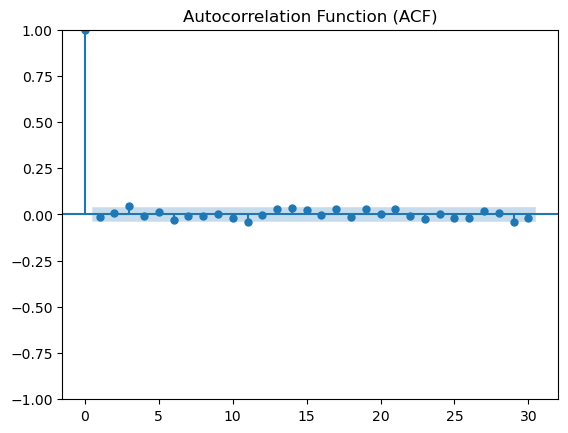

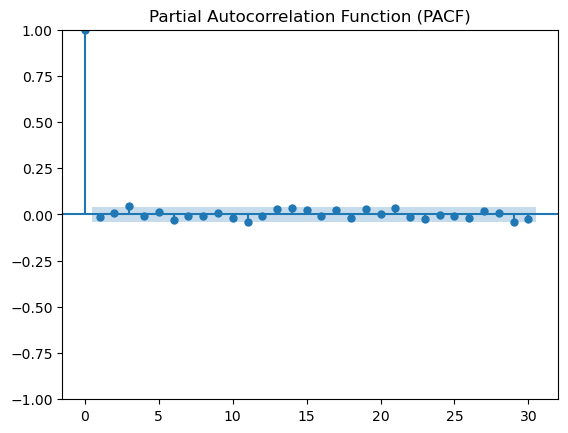

In [8]:
# Plot ACF and PACF to determine the parameters for ARIMA model
plot_acf(df_train['Close'], lags=30)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plot_pacf(df_train['Close'], lags=30)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [9]:
# Check for stationarity using Augmented Dickey-Fuller Test
def adf_test(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] <= 0.05:
        print("Reject the null hypothesis. Data is stationary.")
    else:
        print("Fail to reject the null hypothesis. Data is non-stationary.")

In [10]:
adf_test(df_train['Close'])

ADF Statistic: -27.613952096510705
p-value: 0.0
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Reject the null hypothesis. Data is stationary.


In [11]:
from statsmodels.tsa.arima.model import ARIMA
# Convert 'Close' column of df_train to a one-dimensional array
train_data = np.asarray(df_train['Close'])

# Fit ARIMA model
model = ARIMA(train_data, order=(9,0,2))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2509
Model:                 ARIMA(9, 0, 2)   Log Likelihood              -15024.125
Date:                Mon, 22 Apr 2024   AIC                          30074.250
Time:                        11:31:30   BIC                          30150.009
Sample:                             0   HQIC                         30101.749
                               - 2509                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.9777      5.122     11.514      0.000      48.939      69.017
ar.L1         -0.0077      8.286     -0.001      0.999     -16.248      16.233
ar.L2          0.0042      4.072      0.001      0.9

C:\Users\akshi_sh9bvdj\AppData\Local\Temp\ipykernel_14784\3052477222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tesla_df['forecast'] = [None]*len(df_train) + list(forecast_test)


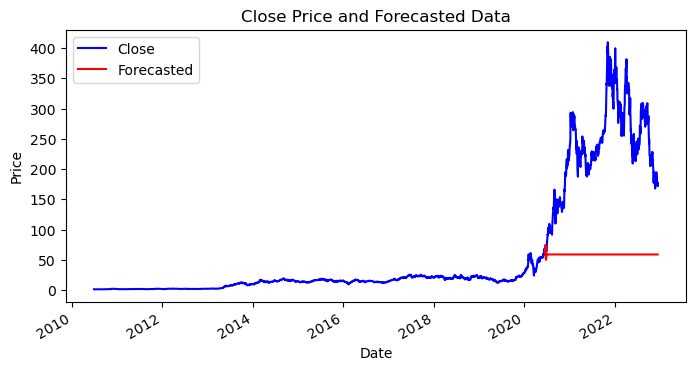

In [12]:
forecast_test = model_fit.forecast(len(df_test))
tesla_df['forecast'] = [None]*len(df_train) + list(forecast_test)
# Plotting 'Close' column and forecasted values using tesla_df.plot
plt.figure(figsize=(8, 4))

# Plotting Close column
tesla_df['Close'].plot(label='Close', color='blue')

# Plotting forecasted values
tesla_df['forecast'].plot(label='Forecasted', color='red')

# Adding labels and legend
plt.title('Close Price and Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Display plot
plt.show()

In [13]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Assuming forecast_test_auto is an array of forecasted 'Close' prices
# Calculate mean absolute error (MAE)
mae = mean_absolute_error(df_test['Close'], forecast_test)

# Calculate mean absolute percentage error (MAPE)
mape = mean_absolute_percentage_error(df_test['Close'], forecast_test)

# Calculate root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(df_test['Close'], forecast_test))

# Print the results
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'RMSE: {rmse}')

MAE: 70.03005694223884
MAPE: 8.947421721357713
RMSE: 91.1796045996645


In [14]:
from sklearn.metrics import r2_score

# Calculate R-squared
r_squared = r2_score(df_test['Close'], forecast_test)

# Calculate adjusted R-squared
n = len(df_test['Close'])
p = 1  # Assuming you have only one predictor
adj_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))

# Print the results
print(f'R-squared: {r_squared}')
print(f'Adjusted R-squared: {adj_r_squared}')

R-squared: -0.0002616958813383974
Adjusted R-squared: -0.0018595580153342173


In [15]:
# Filter out Msft data
msft_df = stocks_df[stocks_df['Name'] == 'MSFT']

# Sort the dataframe by Date
msft_df.sort_values(by='Date', inplace=True)
print(msft_df)

         Name       Date         Low        Open        Volume        High  \
3381936  MSFT 1986-03-13    0.088542    0.088542  1.031789e+09    0.101563   
3381937  MSFT 1986-03-14    0.097222    0.097222  3.081600e+08    0.102431   
3381938  MSFT 1986-03-17    0.100694    0.100694  1.331712e+08    0.103299   
3381939  MSFT 1986-03-18    0.098958    0.102431  6.776640e+07    0.103299   
3381940  MSFT 1986-03-19    0.097222    0.099826  4.789440e+07    0.100694   
...       ...        ...         ...         ...           ...         ...   
3391195  MSFT 2022-12-06  243.779999  250.820007  2.246370e+07  251.860001   
3391196  MSFT 2022-12-07  242.210007  244.830002  2.048150e+07  246.160004   
3391197  MSFT 2022-12-08  243.059998  244.839996  2.261180e+07  248.740005   
3391198  MSFT 2022-12-09  244.160004  244.699997  2.060710e+07  248.309998   
3391199  MSFT 2022-12-12  247.179993  247.445007  1.000066e+07  252.151596   

              Close  Adjusted Close  
3381936    0.097222      

C:\Users\akshi_sh9bvdj\AppData\Local\Temp\ipykernel_14784\712666094.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msft_df.sort_values(by='Date', inplace=True)


In [16]:
# Assuming 'Date' column is present in msft_df and is properly formatted
msft_df['Date'] = pd.to_datetime(msft_df['Date'])
msft_df.set_index('Date', inplace=True)

C:\Users\akshi_sh9bvdj\AppData\Local\Temp\ipykernel_14784\580005611.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msft_df['Date'] = pd.to_datetime(msft_df['Date'])


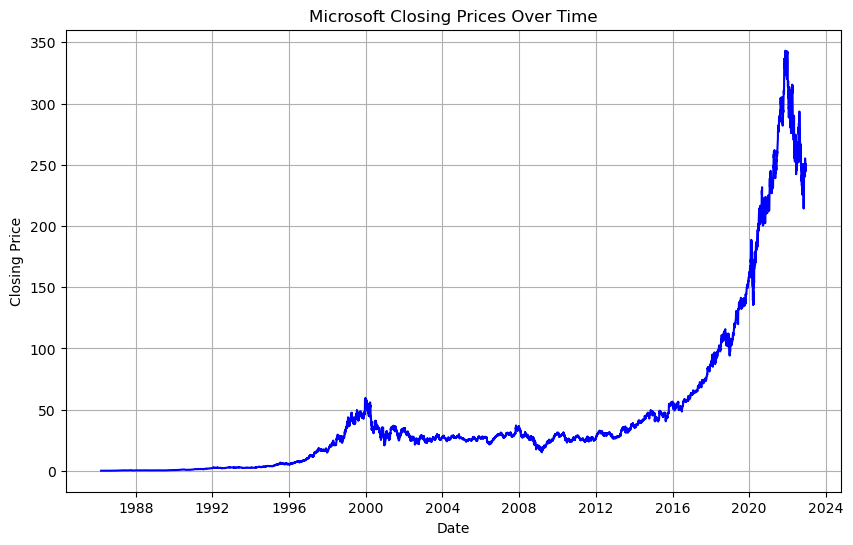

In [17]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(msft_df.index, msft_df['Close'], color='blue')  # Use index for x-axis
plt.title('Microsoft Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()


In [18]:
# Assuming tesla_df is your DataFrame with shape (3137, 8)
train_size = 0.80
test_size = 1 - train_size

# Splitting into training and testing sets
df_train_msft, df_test_msft= train_test_split(msft_df, test_size=test_size, random_state=52)

# Checking the shapes of the resulting DataFrames
print("Shape of df_train:", df_train_msft.shape)
print("Shape of df_test:", df_test_msft.shape)

Shape of df_train: (7411, 7)
Shape of df_test: (1853, 7)


In [19]:
msft_df.shape

(9264, 7)

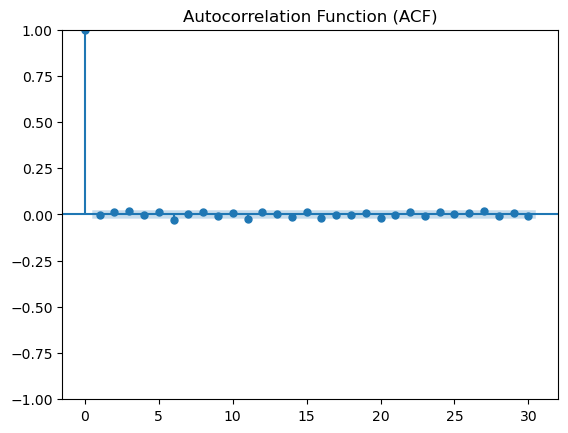

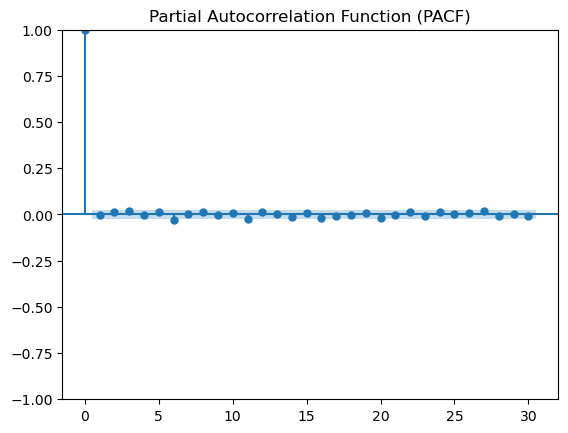

In [20]:
# Plot ACF and PACF to determine the parameters for ARIMA model
plot_acf(df_train_msft['Close'], lags=30)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plot_pacf(df_train_msft['Close'], lags=30)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [21]:
adf_test(df_train_msft['Close'])

ADF Statistic: -35.26494963643886
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject the null hypothesis. Data is stationary.


In [22]:
from statsmodels.tsa.arima.model import ARIMA
# Convert 'Close' column of df_train to a one-dimensional array
train_data_msft = np.asarray(df_train_msft['Close'])

# Fit ARIMA model
model_msft = ARIMA(train_data_msft, order=(5,0,0))
model_fit_msft = model_msft.fit()

# Print model summary
print(model_fit_msft.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7411
Model:                 ARIMA(5, 0, 0)   Log Likelihood              -41572.299
Date:                Mon, 22 Apr 2024   AIC                          83158.598
Time:                        11:31:35   BIC                          83206.973
Sample:                             0   HQIC                         83175.219
                               - 7411                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.3985      1.808     25.104      0.000      41.854      48.943
ar.L1         -0.0047      0.012     -0.389      0.697      -0.029       0.019
ar.L2          0.0117      0.011      1.026      0.3

C:\Users\akshi_sh9bvdj\AppData\Local\Temp\ipykernel_14784\3387170076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msft_df['forecast'] = [None]*len(df_train_msft) + list(forecast_test_msft)


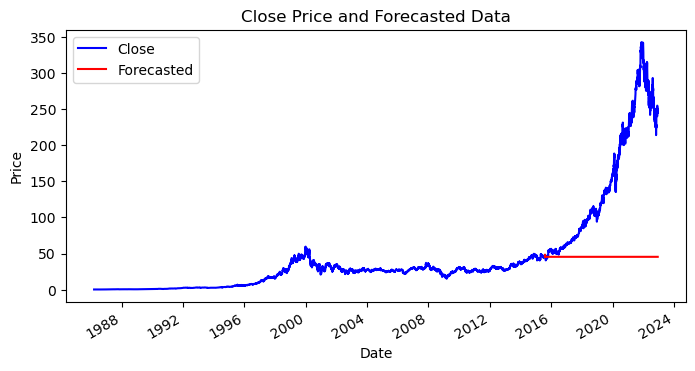

In [23]:
forecast_test_msft = model_fit_msft.forecast(len(df_test_msft))
msft_df['forecast'] = [None]*len(df_train_msft) + list(forecast_test_msft)


# Plotting 'Close' column and forecasted values using msft_df.plot
plt.figure(figsize=(8, 4))

# Plotting Close column
msft_df['Close'].plot(label='Close', color='blue')

# Plotting forecasted values
msft_df['forecast'].plot(label='Forecasted', color='red')

# Adding labels and legend
plt.title('Close Price and Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Display plot
plt.show()

In [24]:
# Assuming forecast_test_auto is an array of forecasted 'Close' prices
# Calculate mean absolute error (MAE)
mae = mean_absolute_error(df_test_msft['Close'], forecast_test_msft)

# Calculate mean absolute percentage error (MAPE)
mape = mean_absolute_percentage_error(df_test_msft['Close'], forecast_test_msft)

# Calculate root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(df_test_msft['Close'], forecast_test_msft))

# Print the results
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'RMSE: {rmse}')

MAE: 42.569157061735474
MAPE: 21.186649008593267
RMSE: 68.36248471867754
